# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

#### Импортируем модули и библиотеки

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler

Функция для подбора кластеров. Выводим оптимальое число кластеров в случае алгоритма KMeans.

In [2]:
# для кластеризации будем использовать алгоритм KMeans, подбирая для него оптимальное число кластеров
# напишем функцию для подбора числа кластеров
def get_kmeans_optimal_clusters_num(data, clusters_num_possible_values: list) -> int:
    k_inertia = []
    for k in clusters_num_possible_values:
        print(f'Trying number of clusters: {k}')  # выводим значения k для оценки прогресса и скорости работы функции
        model = KMeans(n_clusters=k)
        model.fit_predict(data)
        k_inertia.append(model.inertia_)
    
    diff = np.diff(k_inertia)
    diff_r = diff[1:] / diff[:-1]
    result = clusters_num_possible_values[np.argmin(diff_r) + 1]
    print(f'Optimal number of clusters: {result}')
    return result

#### Загружаем данные

In [3]:
df = pd.read_excel('geo.xlsx')
df.head()

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


In [4]:
# ести ли пустые значения
df.isnull().any().any()

False

In [5]:
# оценим, каких отзывов больше
df.comment_class.value_counts()

-1    95147
 1    13659
Name: comment_class, dtype: int64

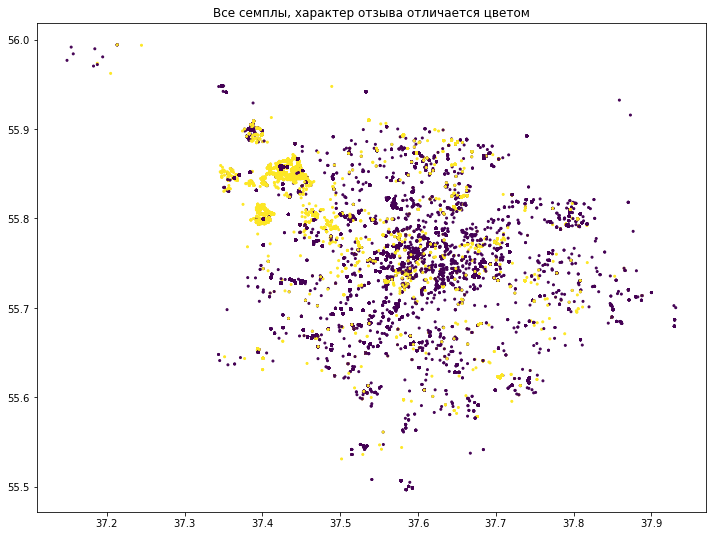

In [30]:
# отобразим графически семплы, цветом выделяя характер отзыва
plt.figure(figsize=(12, 9))
plt.title('Все семплы, характер отзыва отличается цветом')
plt.scatter(df.x, df.y, c=df.comment_class, s=4)
plt.show()

Темные точки - негативные отзывы, их больше.  
Светлые точки - сосредоточены в северо-западной части города.

#### Сделаем кластеризацию не учитывая отзывы

Алгоритм требует нормализации данных.

In [7]:
# нормализуем данные
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[['x', 'y']] = scaler.fit_transform(df_scaled[['x', 'y']])
df_scaled.head()

,Unnamed: 0,x,y,comment_class
0,0,0.367919,0.159553,-1
1,1,0.367919,0.159553,-1
2,2,0.293178,-0.348131,-1
3,3,-0.073819,-0.539880,-1
4,4,-0.009022,-0.496273,-1


In [8]:
# подготовим семплы для классификатора и найдем оптимальное число кластеров (приблизительно)
X_all = np.array(df_scaled[['x', 'y']])

# Рассмотрим диапазон значений от 50 до 160 с шагом 10, число районов в Москве входит в этот диапазон.
n_clusters_min, n_clusters_max, n_clusters_step = 50, 160, 10
n_clusters_possible_values = list(range(n_clusters_min, n_clusters_max, n_clusters_step))
n_clusters_optimal = get_kmeans_optimal_clusters_num(X_all, n_clusters_possible_values)
n_clusters_optimal

Trying number of clusters: 50
Trying number of clusters: 60
Trying number of clusters: 70
Trying number of clusters: 80
Trying number of clusters: 90
Trying number of clusters: 100
Trying number of clusters: 110
Trying number of clusters: 120
Trying number of clusters: 130
Trying number of clusters: 140
Trying number of clusters: 150
Optimal number of clusters: 70


70

In [12]:
# создадим модель для кластеризации на оптимальное число кластеров
model_all = KMeans(n_clusters=n_clusters_optimal)
y_all = model_all.fit_predict(X_all)

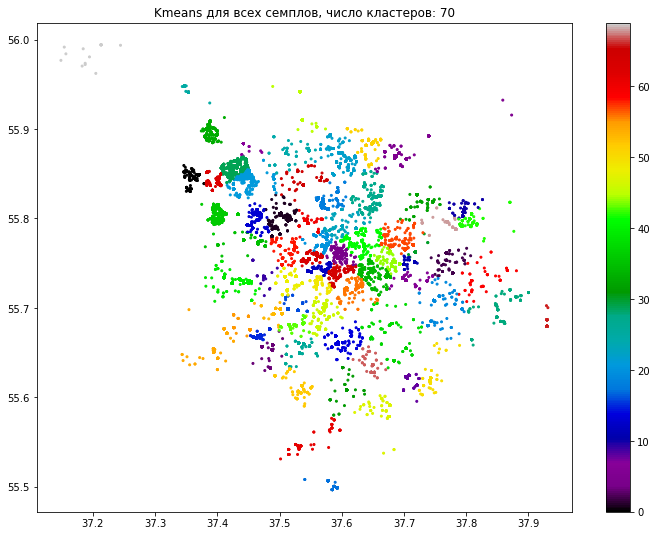

In [13]:
# Отообразим результаты графически
plt.figure(figsize=(12, 9))
plt.title(f'Kmeans для всех семплов, число кластеров: {n_clusters_optimal}')
plt.scatter(df.x, df.y, c=y_all, s=4, cmap="nipy_spectral")
plt.colorbar()
plt.show()

#### Кластеризация положительных и отрицательных отзывов

In [14]:
X_pos = np.array(df_scaled[df_scaled.comment_class == 1][['x', 'y']])
X_neg = np.array(df_scaled[df_scaled.comment_class == -1][['x', 'y']])

In [15]:
# для положительных и отрицательных отзывов оптимальное число кластеров может отличаться от общего,  
# поэтому считаем отдельно
n_clusters_optimal_pos = get_kmeans_optimal_clusters_num(X_pos, n_clusters_possible_values)
n_clusters_optimal_neg = get_kmeans_optimal_clusters_num(X_neg, n_clusters_possible_values)

Trying number of clusters: 50
Trying number of clusters: 60
Trying number of clusters: 70
Trying number of clusters: 80
Trying number of clusters: 90
Trying number of clusters: 100
Trying number of clusters: 110
Trying number of clusters: 120
Trying number of clusters: 130
Trying number of clusters: 140
Trying number of clusters: 150
Optimal number of clusters: 60
Trying number of clusters: 50
Trying number of clusters: 60
Trying number of clusters: 70
Trying number of clusters: 80
Trying number of clusters: 90
Trying number of clusters: 100
Trying number of clusters: 110
Trying number of clusters: 120
Trying number of clusters: 130
Trying number of clusters: 140
Trying number of clusters: 150
Optimal number of clusters: 110


In [16]:
# создадим и обучим модели для работы с положительными и отрицательными отзывами
model_pos = KMeans(n_clusters=n_clusters_optimal_pos)
y_pos = model_pos.fit_predict(X_pos)
model_neg = KMeans(n_clusters=n_clusters_optimal_neg)
y_neg = model_neg.fit_predict(X_neg)

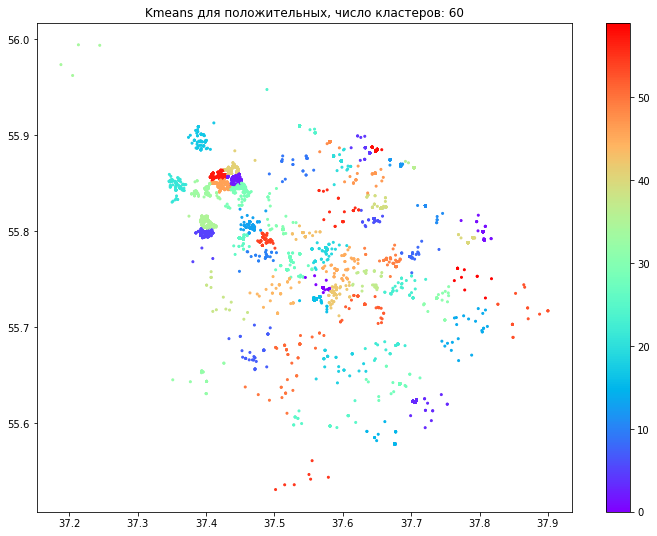

In [17]:
# отобразим результаты для положительных отзывов
plt.figure(figsize=(12, 9))
plt.title(f'Kmeans для положительных, число кластеров: {n_clusters_optimal_pos}')
plt.scatter(df[df.comment_class == 1].x, df[df.comment_class == 1].y, c=y_pos, s=4, cmap="rainbow")
plt.colorbar()
plt.show()

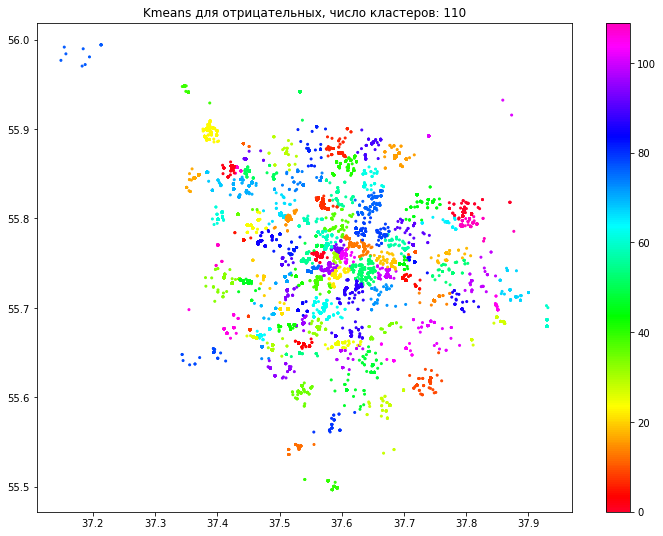

In [18]:
# отобразим результаты для отрицательных отзывов
plt.figure(figsize=(12, 9))
plt.title(f'Kmeans для отрицательных, число кластеров: {n_clusters_optimal_neg}')
plt.scatter(df[df.comment_class == -1].x, df[df.comment_class == -1].y, c=y_neg, s=4, cmap="gist_rainbow")
plt.colorbar()
plt.show()

#### Оценка активности жителей в различных районах

In [19]:
# для удобства добавим к оригинальному датасету номер кластера для каждого семпла
# уберём характер отзыва
df_clustered = df[['x', 'y']].copy()
df_clustered['cluster'] = y_all
df_clustered.head()

,x,y,cluster
0,37.612416,55.777454,41
1,37.612416,55.777454,41
2,37.603298,55.742108,64
3,37.558526,55.728758,49
4,37.566431,55.731794,49


In [20]:
# при помощи метода value_counts() получаем значения числа голосов в каждом кластере, отсортированные по убыванию
clusters = df_clustered.cluster.value_counts()
clusters

7     7346
15    6427
44    5700
20    5029
13    4490
      ... 
59     140
54     108
61     103
66      74
69      16
Name: cluster, Length: 70, dtype: int64

In [21]:
# перенумеруем кластеры по убыванию голосов и добавим столбец с новыми значениями кластеров для всех семплов
df_clustered['new_cluster'] = df_clustered['cluster'].apply(lambda c: clusters.index.get_loc(c))
df_clustered.head()

,x,y,cluster,new_cluster
0,37.612416,55.777454,41,18
1,37.612416,55.777454,41,18
2,37.603298,55.742108,64,35
3,37.558526,55.728758,49,22
4,37.566431,55.731794,49,22


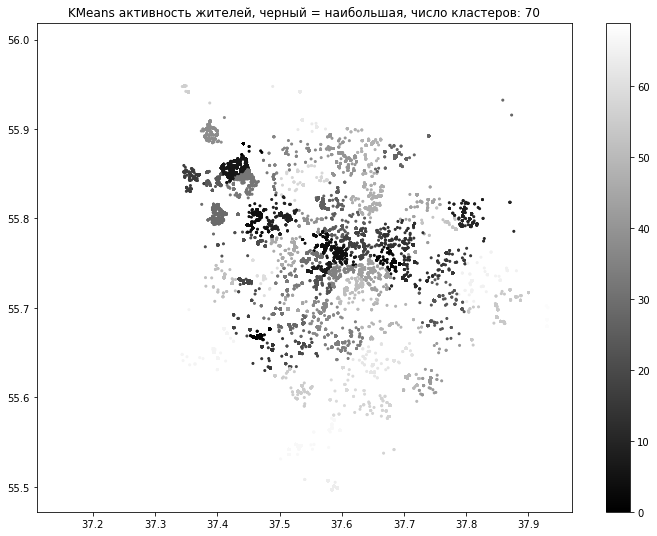

In [22]:
# Отобразим графически распределение по кластерам по убыванию числа семплов в них
plt.figure(figsize=(12, 9))
plt.title(f'KMeans активность жителей, черный = наибольшая, число кластеров: {clusters.size}')
plt.scatter(df_clustered.x, df_clustered.y, c=df_clustered.new_cluster, cmap='gray', s=4)
plt.colorbar()
plt.show()

## Используем метод DBSCAN для оценки активности

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94
 95 96 97 98 99]


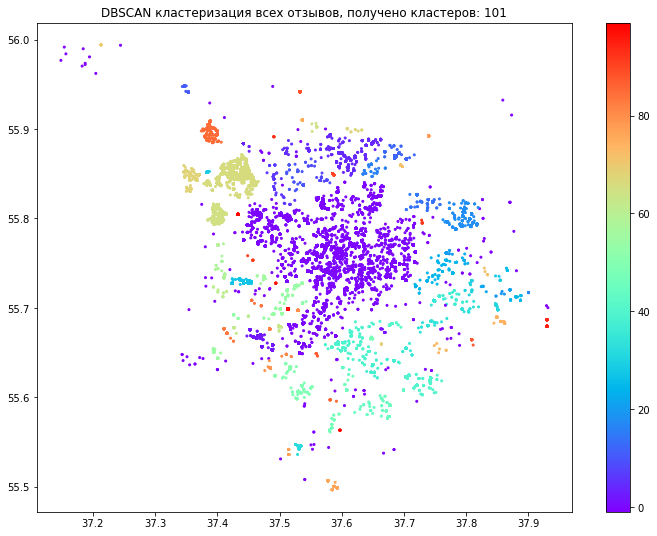

In [32]:
# сначала кластеризуем все семплы
model_all_dbscan = DBSCAN(eps=0.1)  # значение параметра было примерно подобрано экспериментально
y_all_dbscan = model_all_dbscan.fit_predict(X_all)
print(np.unique(model_all_dbscan.labels_))
plt.figure(figsize=(12, 9))
plt.title(f'DBSCAN кластеризация всех отзывов, получено кластеров: {np.unique(model_all_dbscan.labels_).size}')
plt.scatter(df.x, df.y, c=model_all_dbscan.labels_, s=4, cmap="rainbow")
plt.colorbar()
plt.show()

In [24]:
# исключим те семлы, которые DBSCAN отнес в категорию выбросов
df_dbscan = df[['x', 'y']].copy()
df_dbscan['cluster'] = model_all_dbscan.labels_
print(df_dbscan.shape)
df_dbscan = df_dbscan[df_dbscan.cluster != -1]
print(df_dbscan.shape)
df_dbscan.cluster.value_counts()

(108806, 3)
(108638, 3)


0     54429
2     11057
3      7341
18     6696
66     4942
      ...  
96        6
73        6
69        5
93        5
19        5
Name: cluster, Length: 100, dtype: int64

In [25]:
# по аналогии с KMeans, добавляем столбец с новыми номерами кластеров, учитывающими число семплов в них
clusters_dbscan = df_dbscan.cluster.value_counts()
df_dbscan['new_cluster'] = df_dbscan['cluster'].apply(lambda c: clusters_dbscan.index.get_loc(c))
df_dbscan.tail()

,x,y,cluster,new_cluster
108801,37.454528,55.792331,0,0
108802,37.384325,55.899068,85,15
108803,37.421066,55.848756,66,4
108804,37.448509,55.793065,0,0
108805,37.451249,55.836620,66,4


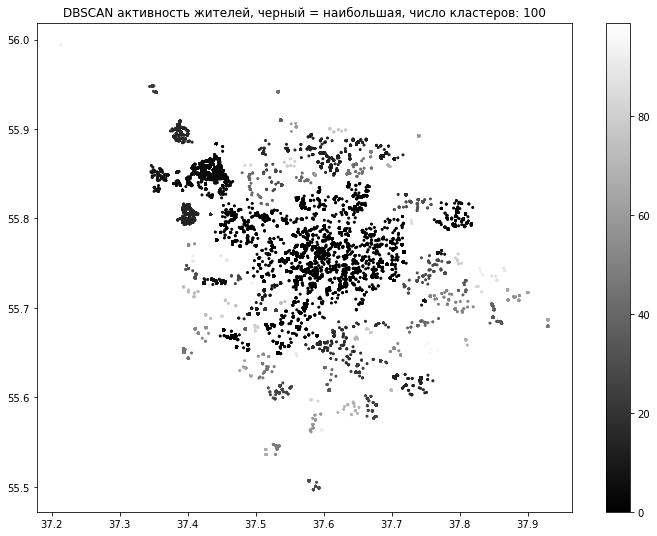

In [26]:
plt.figure(figsize=(12, 9))
plt.title(f'DBSCAN активность жителей, черный = наибольшая, число кластеров: {clusters_dbscan.size}')
plt.scatter(df_dbscan.x, df_dbscan.y, c=df_dbscan.new_cluster, s=4, cmap="gray")
plt.colorbar()
plt.show()

### Выводы
На Северо-Западе повышена активность, преобладают положительные отзывы.  
В центре также наблюдается активность, но отзывы отрицательны.  
Это единственные два района с повышенной активностью.